In [41]:
import pandas as pd
import os
import plotting
import importlib
importlib.reload(plotting)
import math
from typing import List
pd.options.display.max_rows = 4000

In [42]:
def load_data(data_src):
    curve_data = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        curve_data.append(df)
        filename_list.append(filename)
    return curve_data, filename_list

data_src = "data/cleaned_data"
curve_data, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, curve_data))

In [43]:
data_features = pd.read_csv("data/features.csv")
data_features = plotting.extract_needed_cols(data_features, remove_cols=['feifeis_ylabels', 'liams_ylabels', 'distances'])
clustering_features = plotting.extract_numerical_features(data_features)


ylabel_name = 'marions_ylabels'
# ylabel_name = 'marions_ylabels_deduction'
ylabel_to_cluster_num = {'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
data_features[f'{ylabel_name}_nums'] = data_features[ylabel_name].map(ylabel_to_cluster_num)
marions_labeled_data = data_features[data_features[ylabel_name].notna()].copy() # removes NaN's which correspond to non-labled data
print(f'marions_labeled_data: \n{marions_labeled_data[:3]}')

marions_labeled_data: 
    max_depth  max_resistance  num_peaks  largest_force_drop  curve_shape  \
2   -0.188058        0.842728  -0.245575           -0.527665     0.933011   
7    0.789160       -0.386779  -0.245575            0.285496    -0.563611   
16  -0.490027        0.946804  -0.245575           -0.793522     1.147447   

              filenames marions_ylabels marions_ylabels_deduction  \
2   WS23_L3_T1_P_16.csv            ES-B                      ES-B   
7    WS23_L2_T1_P_4.csv              LS                        LS   
16  WS23_L3_T1_P_11.csv              ES                        ES   

    marions_ylabels_nums  
2                    0.0  
7                    5.0  
16                   9.0  


In [44]:
def find_labels_centroids(labeled_data: pd.DataFrame, ylabel_to_cluster_num:dict[str,int], ylabel_name:str) -> pd.DataFrame:
    labeled_data = labeled_data.copy()
    numerical_data = plotting.extract_numerical_features(labeled_data)
    label_centroids = []
    for label, label_num in ylabel_to_cluster_num.items():
        if label not in labeled_data[ylabel_name].values: continue
        label_data = numerical_data[labeled_data[ylabel_name] == label]
        label_centroid = label_data.mean(axis=0).tolist() # drop cols for mean calculation
        label_centroid.extend([label, label_num]) # append these onto the end
        label_centroids.append(label_centroid)
    return_cols = numerical_data.columns.tolist()
    return_cols.extend([ylabel_name, f'{ylabel_name}_nums'])
    return pd.DataFrame(data=label_centroids, columns=return_cols)

label_centroids = find_labels_centroids(marions_labeled_data, ylabel_to_cluster_num, ylabel_name)
print(f'label_centroids: \n{label_centroids[:3]}')

label_centroids: 
   max_depth  max_resistance  num_peaks  largest_force_drop  curve_shape  \
0   0.710127       -0.970371   0.352416            1.710284     0.020179   
1   1.304859       -1.065781   0.450452            1.861259    -0.880518   
2   0.437705       -0.117461  -0.024335           -0.273579     0.822304   

  marions_ylabels  marions_ylabels_nums  
0            ES-B                     0  
1           ES-BW                     1  
2            ES-S                     2  


In [45]:
def euclidean_distance(x: pd.Series, y: pd.Series) -> float:
    return math.sqrt(((y - x) ** 2).sum())

def find_closest_centroid(unlabeled_data:pd.DataFrame, marions_centroids:pd.DataFrame, ylabel_name) -> pd.DataFrame:
    unlabeled_num_data = plotting.extract_numerical_features(unlabeled_data) # returns a new object
    unlabeled_non_num_data = unlabeled_data.drop(unlabeled_num_data.columns, axis=1)
    
    pseudo_label_list = []
    pseudo_label_num_list = []
    for i, depth_res_curve in unlabeled_num_data.iterrows():
        min_distance = float('inf')
        min_distance_label = ''
        min_distance_label_num = 0
        for j, marions_label_centroid in marions_centroids.iterrows():
            curve_to_label_mean_distance = euclidean_distance(depth_res_curve, marions_label_centroid)
            if curve_to_label_mean_distance < min_distance:
                min_distance = curve_to_label_mean_distance
                min_distance_label = marions_label_centroid[ylabel_name]
                min_distance_label_num = marions_label_centroid[f'{ylabel_name}_nums']
        pseudo_label_list.append(min_distance_label)
        pseudo_label_num_list.append(min_distance_label_num)
    unlabeled_num_data[f'pseudo_{ylabel_name}'] = pseudo_label_list
    unlabeled_num_data[f'pseudo_{ylabel_name}_nums'] = pseudo_label_num_list

    return pd.concat([unlabeled_num_data, unlabeled_non_num_data], axis=1)

pseudo_labeled_data = find_closest_centroid(data_features, label_centroids, ylabel_name)
print(f'pseudo_labeled_data: \n{pseudo_labeled_data[:3]}')

pseudo_labeled_data: 
   max_depth  max_resistance  num_peaks  largest_force_drop  curve_shape  \
0   1.574629        0.844172  -0.245575            0.691775    -1.623511   
1  -0.462706        0.122593  -0.245575           -0.684988    -0.412122   
2  -0.188058        0.842728  -0.245575           -0.527665     0.933011   

  pseudo_marions_ylabels  pseudo_marions_ylabels_nums  \
0                     LS                            5   
1                   LS/F                            7   
2                      F                            6   

                         filenames marions_ylabels marions_ylabels_deduction  \
0    _Fri_Aug__8_09_59_47_2025.csv             NaN                       NaN   
1  WS25_Aug5_Loc1A_T1_F10_0958.csv             NaN                       NaN   
2              WS23_L3_T1_P_16.csv            ES-B                      ES-B   

   marions_ylabels_nums  
0                   NaN  
1                   NaN  
2                   0.0  


In [46]:
def find_changed_ylabel_data(labeled_data:pd.DataFrame, pseudo_labeled_data:pd.DataFrame, ylabel_name:str):
    ylabel_idxs = labeled_data.index # idxs of labeled data points
    pseudo_labels_of_labeled_data = pseudo_labeled_data.loc[ylabel_idxs]
    diff_mask = (labeled_data[ylabel_name] != pseudo_labels_of_labeled_data[f'pseudo_{ylabel_name}'])
    changed_label_idxs = labeled_data[diff_mask].index.tolist()
    for i in changed_label_idxs:
        print(f'{labeled_data['filenames'].loc[i]} changed label {labeled_data[f'{ylabel_name}'].loc[i]} -> {pseudo_labeled_data[f'pseudo_{ylabel_name}'].loc[i]}')
    return changed_label_idxs

changed_ylabel_idxs = find_changed_ylabel_data(marions_labeled_data, pseudo_labeled_data, ylabel_name)
# print(f'changed_ylabel_idxs: {changed_ylabel_idxs}')

WS23_L3_T1_P_16.csv changed label ES-B -> F
WS23_L3_T1_P_11.csv changed label ES -> F
WS23_L2_T1_P_12.csv changed label ES-S -> LS/F
WS23_L2_T1_P_9.csv changed label ES-S -> LS
WS23_L2_T1_P_13.csv changed label ES-D -> ES
WS23_L2_T1_P_6.csv changed label ES-D -> LS
WS23_L2_T1_P_16.csv changed label ES-DB -> ES
WS23_L2_T1_P_2.csv changed label LS -> ES-D
WS23_L3_T1_P_4.csv changed label ES-B -> ES-DB
WS23_L2_T1_P_10.csv changed label ES-D -> F
WS23_L3_T1_P_15.csv changed label ES-D -> ES-S
WS23_L3_T1_P_1.csv changed label ES-B -> ES-S-Plates
WS23_L3_T1_P_13.csv changed label F -> ES-D
WS23_L2_T1_P_1.csv changed label LS -> ES-S-Plates
WS23_L3_T1_P_3.csv changed label ES-S -> ES-S-Plates
WS23_L2_T1_P_3.csv changed label ES-D -> ES-S-Plates
WS23_L3_T1_P_22.csv changed label ES -> F
WS23_L3_T1_P_2.csv changed label ES-B -> ES-DB
WS23_L3_T1_P_5.csv changed label ES-B -> ES-BW
WS23_L2_T1_P_15.csv changed label ES-D -> F
WS23_L3_T1_P_14.csv changed label ES-D -> ES-BW
WS23_L3_T1_P_23.csv chan

# Plot Labeled Data Only

Indexes of curves assigned to purple cluster: 
idx: 26, filename: WS23_L2_T1_P_13.csv
idx: 29, filename: WS23_L2_T1_P_6.csv
idx: 44, filename: WS23_L2_T1_P_5.csv
idx: 57, filename: WS23_L2_T1_P_10.csv
idx: 64, filename: WS23_L3_T1_P_15.csv
idx: 89, filename: WS23_L2_T1_P_3.csv
idx: 106, filename: WS23_L2_T1_P_15.csv
idx: 107, filename: WS23_L3_T1_P_14.csv
idx: 151, filename: WS23_L2_T1_P_11.csv
idx: 154, filename: WS23_L3_T1_P_10.csv
idx: 162, filename: WS23_L2_T1_P_7.csv


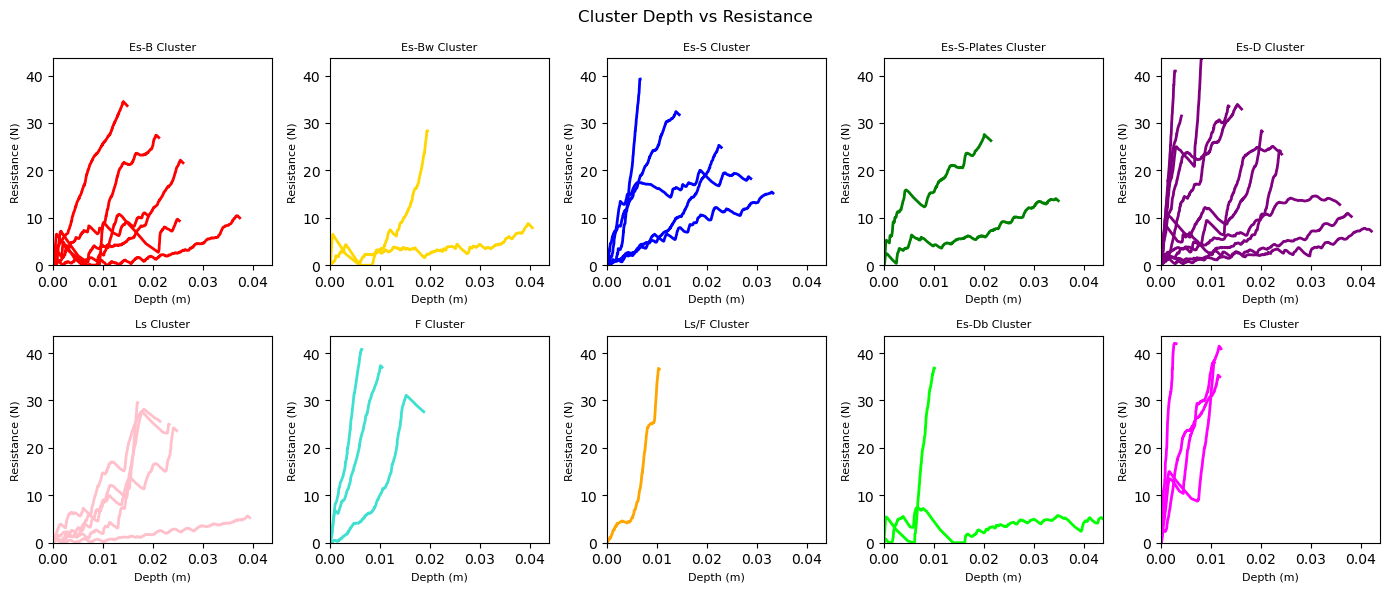

In [47]:
plotting.get_curve_idx_from_cluster_color('purple', marions_labeled_data[f'{ylabel_name}_nums'], marions_labeled_data.index, data_features)

plotting.plot_clusters_seperately(marions_labeled_data[f'{ylabel_name}_nums'], curve_data, ylabel_name,
                                  cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  bold_idxs=marions_labeled_data.index.tolist()) 
plotting.plot_pca(marions_labeled_data, marions_labeled_data[f'{ylabel_name}_nums'], graph_title="Clustering Labeled Data", num_pc=3, ylabel_name=ylabel_name, centroids=label_centroids)

# Plot Corrected Labeling

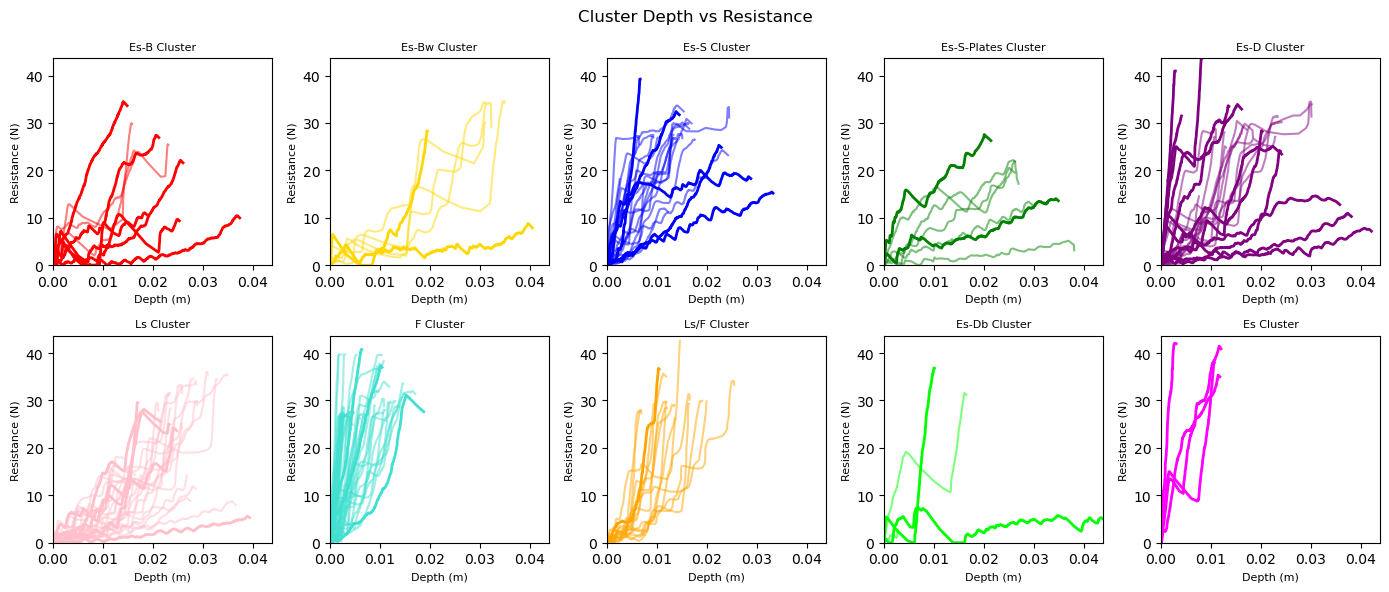

In [48]:
def correct_pseudo_ylabels_to_actual(pseudo_labeled_data:pd.DataFrame, actual_labeled_data:pd.DataFrame, ylabel_name, changed_ylabel_idxs):
    corrected_pseudo_labeled_data = pseudo_labeled_data.copy()
    corrected_pseudo_labeled_data.loc[changed_ylabel_idxs, f'pseudo_{ylabel_name}'] = actual_labeled_data[ylabel_name]
    corrected_pseudo_labeled_data.loc[changed_ylabel_idxs, f'pseudo_{ylabel_name}_nums'] = actual_labeled_data[f'{ylabel_name}_nums']
    return corrected_pseudo_labeled_data

corrected_pseudo_labeled_data = correct_pseudo_ylabels_to_actual(pseudo_labeled_data, marions_labeled_data, ylabel_name, changed_ylabel_idxs)

plotting.plot_clusters_seperately(corrected_pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'], 
                                  curve_data, ylabel_name, cluster_category_names=list(ylabel_to_cluster_num.keys()), 
                                  pseudo_corrections=marions_labeled_data)
plotting.plot_pca(corrected_pseudo_labeled_data, corrected_pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'], graph_title="Clustering Corrected Pseudo Labeled Data", num_pc=3, ylabel_name=ylabel_name, centroids=label_centroids)


# Plot Un-corrected Labeling

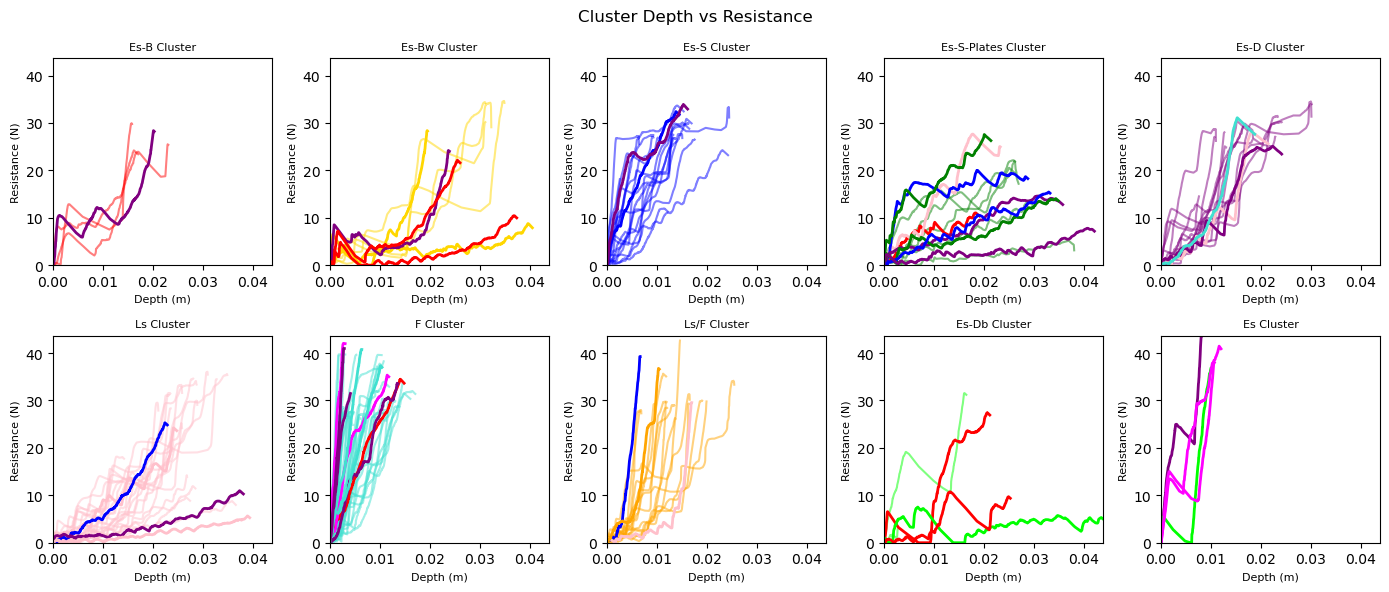

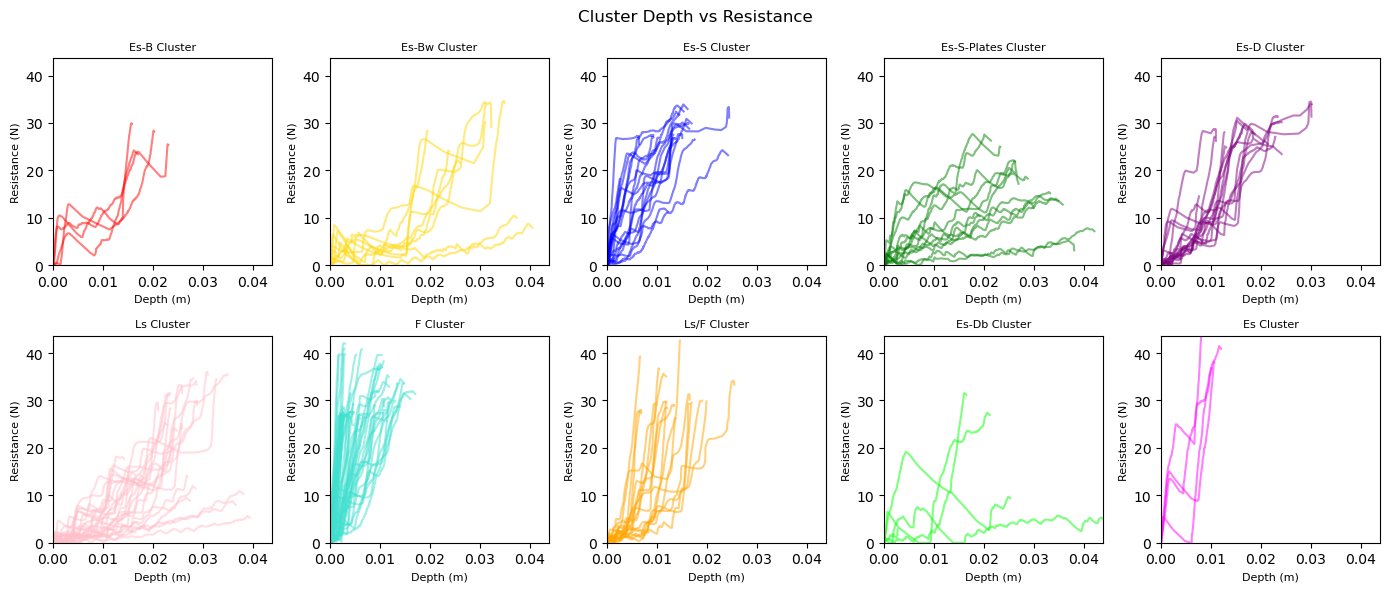

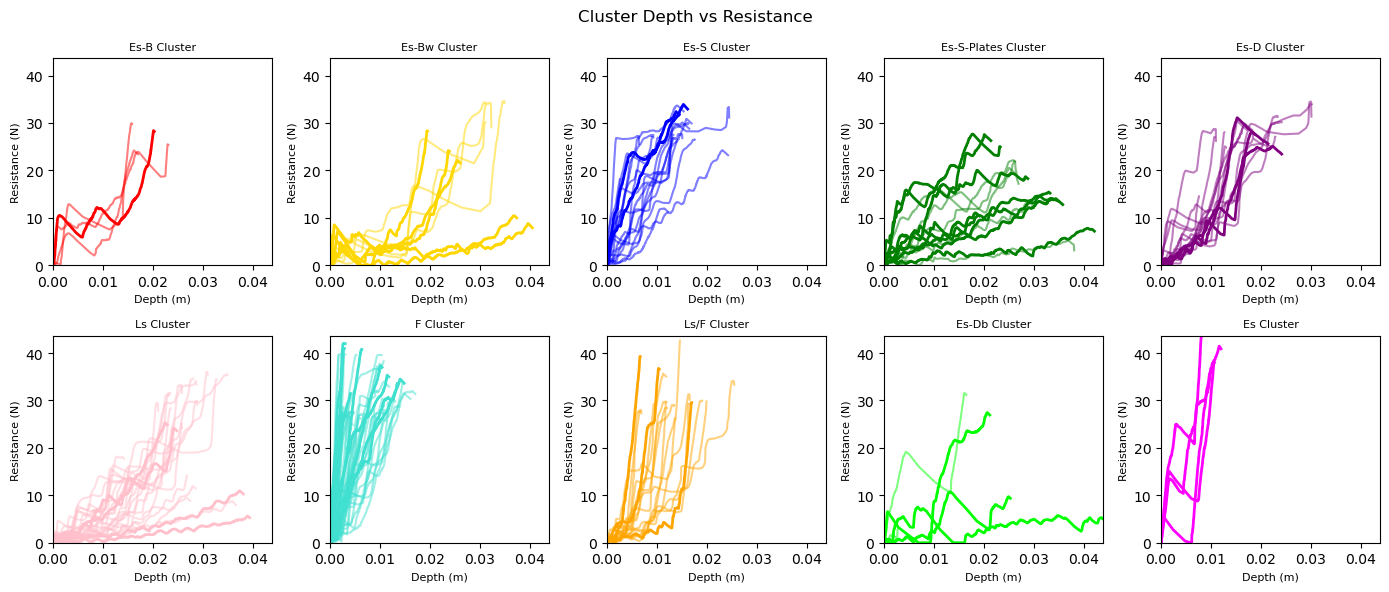

In [49]:

plotting.plot_clusters_seperately(pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'],
                                  curve_data, ylabel_name, cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  pseudo_corrections=marions_labeled_data)
plotting.plot_clusters_seperately(pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'],
                                  curve_data, ylabel_name, cluster_category_names=list(ylabel_to_cluster_num.keys()),)
plotting.plot_clusters_seperately(pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'],
                                  curve_data, ylabel_name, cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  bold_idxs=marions_labeled_data.index)
plotting.plot_pca(pseudo_labeled_data, pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'], graph_title="Clustering Un-corrected Pseudo Labeled Data", num_pc=3, ylabel_name=ylabel_name, centroids=label_centroids)


# Clustering data with ES-D removed (Corrected)

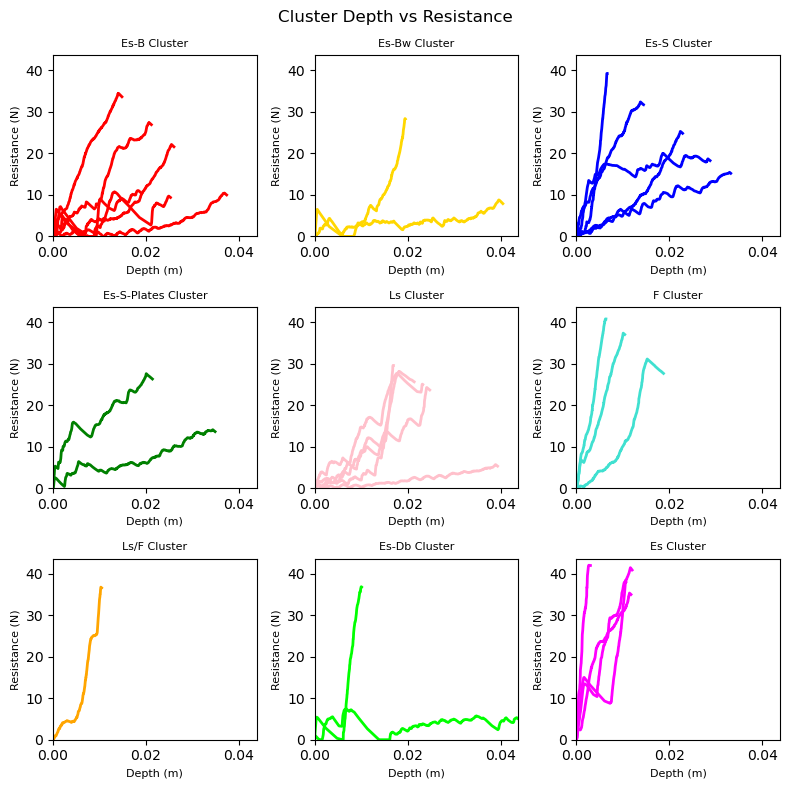

Corrected
WS23_L3_T1_P_16.csv changed label ES-B -> F
WS23_L3_T1_P_11.csv changed label ES -> F
WS23_L2_T1_P_12.csv changed label ES-S -> LS/F
WS23_L2_T1_P_9.csv changed label ES-S -> LS
WS23_L2_T1_P_16.csv changed label ES-DB -> ES
WS23_L3_T1_P_4.csv changed label ES-B -> ES-DB
WS23_L3_T1_P_1.csv changed label ES-B -> ES-S-Plates
WS23_L3_T1_P_13.csv changed label F -> LS
WS23_L2_T1_P_1.csv changed label LS -> ES-S-Plates
WS23_L3_T1_P_3.csv changed label ES-S -> ES-S-Plates
WS23_L3_T1_P_22.csv changed label ES -> F
WS23_L3_T1_P_2.csv changed label ES-B -> ES-DB
WS23_L3_T1_P_5.csv changed label ES-B -> ES-BW
WS23_L3_T1_P_23.csv changed label LS -> LS/F
WS23_L3_T1_P_7.csv changed label ES-B -> ES-BW
WS23_L2_T1_P_17.csv changed label ES-S -> ES-S-Plates


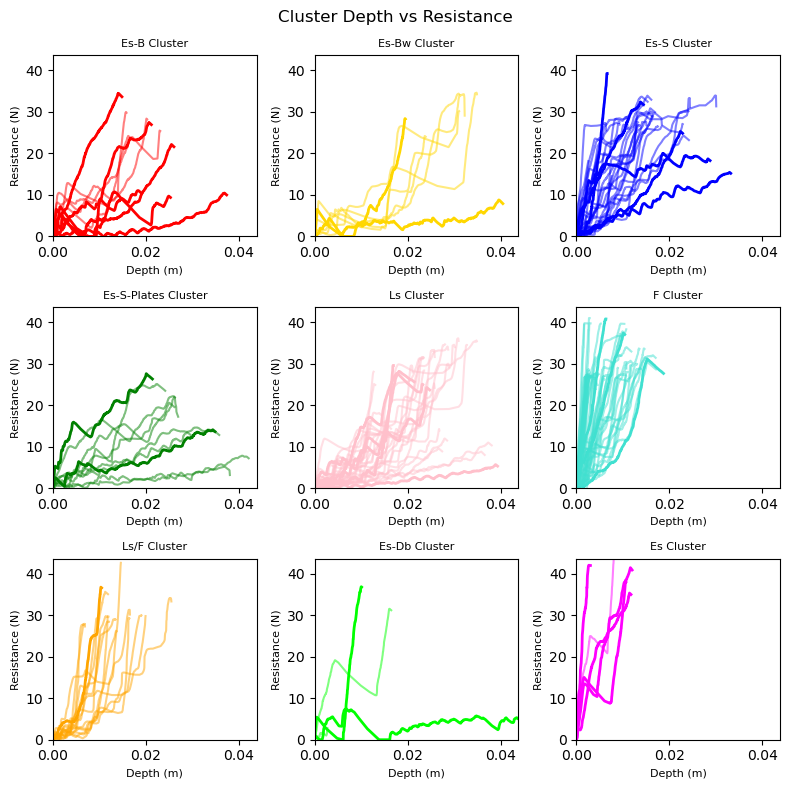

Uncorrected
Indexes of curves assigned to pink cluster: 
idx: 0, filename: _Fri_Aug__8_09_59_47_2025.csv
idx: 7, filename: WS23_L2_T1_P_4.csv
idx: 15, filename: _Fri_Aug__8_08_36_57_2025.csv
idx: 17, filename: WS25_Aug6_Loc1A_T1_F22_0653.csv
idx: 18, filename: WS23_L3_T1_P_25.csv
idx: 19, filename: WS23_L1_T1_P_5.csv
idx: 24, filename: WS23_L2_T1_P_9.csv
idx: 29, filename: WS23_L2_T1_P_6.csv
idx: 31, filename: _Mon_Aug__4_20_05_03_2025.csv
idx: 34, filename: WS23_L2_T1_P_2.csv
idx: 36, filename: _Tue_Aug__5_06_05_11_2025.csv
idx: 40, filename: WS25_Aug5_Loc1A_T1_F2_0919.csv
idx: 46, filename: WS23_L3_T1_P_29.csv
idx: 52, filename: WS25_Aug6_Loc1A_T1_F32_0714.csv
idx: 74, filename: WS23_L1_T1_P_9.csv
idx: 75, filename: WS23_L3_T1_P_0.csv
idx: 79, filename: WS23_L3_T1_P_13.csv
idx: 86, filename: _Fri_Aug__8_08_27_20_2025.csv
idx: 87, filename: WS25_Aug8_Loc1A_WS_F5_0907_Attempt2.csv
idx: 91, filename: WS25_Aug5_Loc1A_T1_F25_1058.csv
idx: 109, filename: WS25_Aug6_Loc1A_TMC_F1_0957.csv
idx

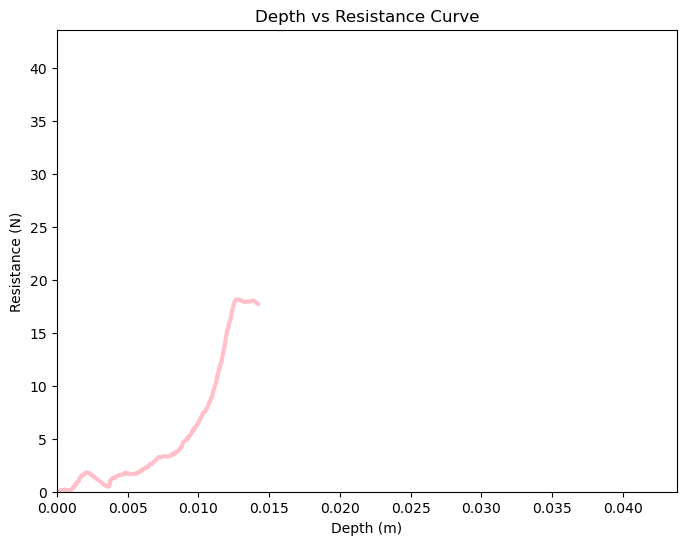

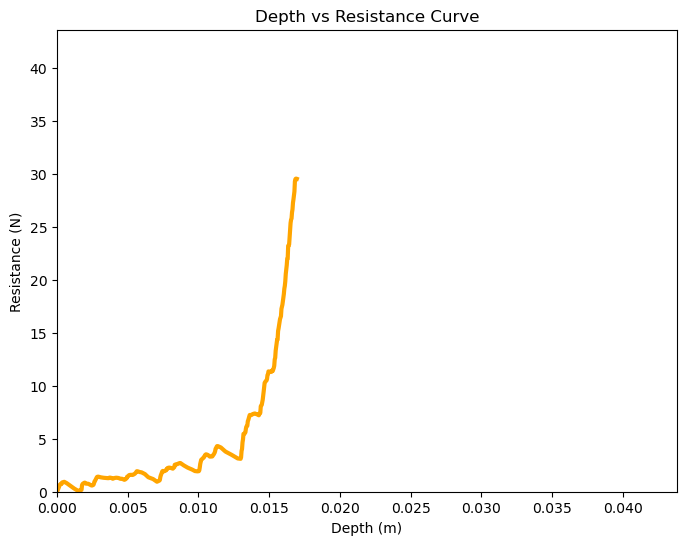

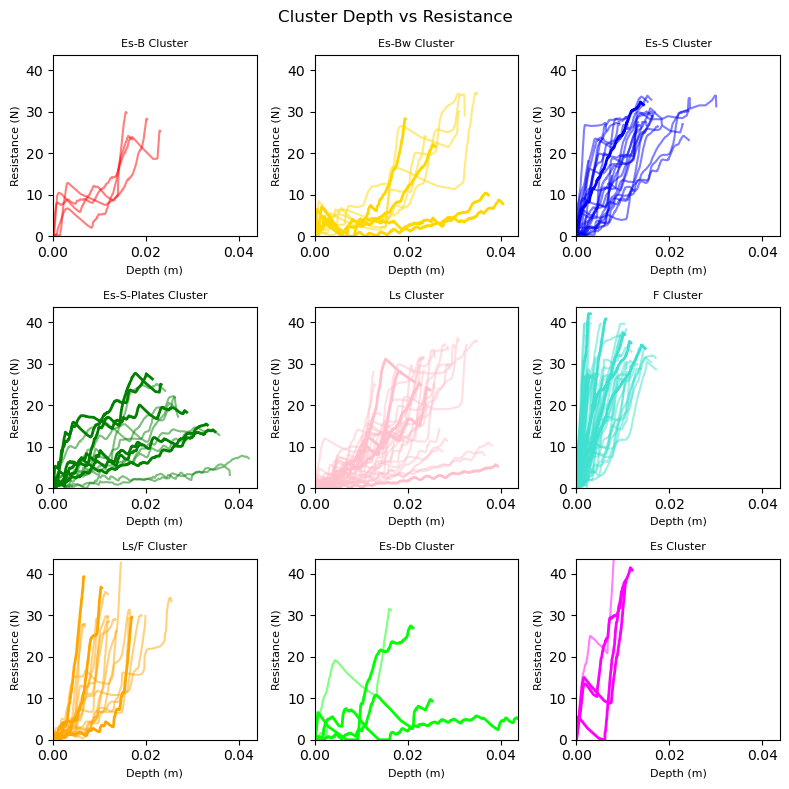

    Eigenvalue  Proportion  Cumulative
PC                                    
1     1.854076    0.368554    0.368554
2     1.281399    0.254717    0.623271
3     0.819826    0.162965    0.786237
4     0.769392    0.152940    0.939177
5     0.305983    0.060823    1.000000


                         PC1       PC2       PC3       PC4       PC5
max_depth           0.598059 -0.263937 -0.314969 -0.243658  0.643497
max_resistance     -0.497251 -0.440291  0.116985  0.511518  0.532494
num_peaks           0.345202  0.510176  0.658363  0.290372  0.320622
largest_force_drop  0.499043 -0.266228 -0.174982  0.704104 -0.392042
curve_shape        -0.163888  0.636650 -0.650422  0.314486  0.214166


In [50]:
# should labels be fixed or not
labeled_data_esd_removed = marions_labeled_data[marions_labeled_data[ylabel_name] != 'ES-D'].copy()
marions_labeled_data_esd_removed = marions_labeled_data[marions_labeled_data[ylabel_name] != 'ES-D']

# print('Labeled data only')
plotting.plot_clusters_seperately(labeled_data_esd_removed[f'{ylabel_name}_nums'], curve_data, ylabel_name, bold_idxs=labeled_data_esd_removed.index.tolist(), cluster_category_names=list(ylabel_to_cluster_num.keys()))

label_centroids_esd_removed = find_labels_centroids(labeled_data_esd_removed, ylabel_to_cluster_num, ylabel_name)
pseudo_data_esd_removed = find_closest_centroid(data_features, label_centroids_esd_removed, ylabel_name)

print('Corrected')
changed_ylabel_idxs = find_changed_ylabel_data(labeled_data_esd_removed, pseudo_data_esd_removed, ylabel_name)
corrected_pseudo_data_esd_removed = correct_pseudo_ylabels_to_actual(pseudo_data_esd_removed, marions_labeled_data, ylabel_name, changed_ylabel_idxs)
plotting.plot_clusters_seperately(corrected_pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], curve_data, ylabel_name, cluster_category_names=list(ylabel_to_cluster_num.keys()), pseudo_corrections=labeled_data_esd_removed)
plotting.plot_pca(corrected_pseudo_data_esd_removed, corrected_pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], 3, graph_title="", ylabel_name=ylabel_name, centroids=label_centroids_esd_removed)

print('Uncorrected')
# find_changed_ylabel_data(marions_labeled_data_esd_removed, pseudo_data_esd_removed, ylabel_name)
plotting.get_curve_idx_from_cluster_color('pink', pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], pseudo_data_esd_removed.index, data_features)
plotting.get_curve_idx_from_cluster_color('orange', pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], pseudo_data_esd_removed.index, data_features)
# print(pseudo_data_esd_removed[:3])
indicies = pseudo_data_esd_removed[pseudo_data_esd_removed['filenames'].isin(['WS23_L3_T1_P_23.csv','WS23_L3_T1_P_25.csv'])].index
plotting.plot_specific_curves([indicies.tolist()[0]], curve_data, data_features, color='pink')
plotting.plot_specific_curves([indicies.tolist()[1]], curve_data, data_features, color='orange')


plotting.plot_clusters_seperately(pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], curve_data, ylabel_name, cluster_category_names=list(ylabel_to_cluster_num.keys()), bold_idxs=marions_labeled_data_esd_removed.index)
# print(label_centroids_esd_removed)
plotting.plot_pca(pseudo_data_esd_removed, pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], 3, graph_title="", ylabel_name=ylabel_name, centroids=label_centroids_esd_removed,
                only_plot_cluster_labels=[])
plotting.pca_analysis(pseudo_data_esd_removed)
# ylabel_to_cluster_num = {'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
# print(pseudo_data_esd_removed[:3])

# print(pseudo_data_esd_removed.dropna(subset=[ylabel_name])[['filenames', ylabel_name]])
plotting.plot_pseudo_labeling_steps(pseudo_data_esd_removed, pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], 3, graph_title="", ylabel_name=ylabel_name, centroids=label_centroids_esd_removed,
                specific_clusters=[3,6])